In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OrdinalEncoder 
from IPython.display import Image  
from six import StringIO
from sklearn import tree
import pydotplus
import graphviz 


In [138]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [139]:
data = pd.read_csv("train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

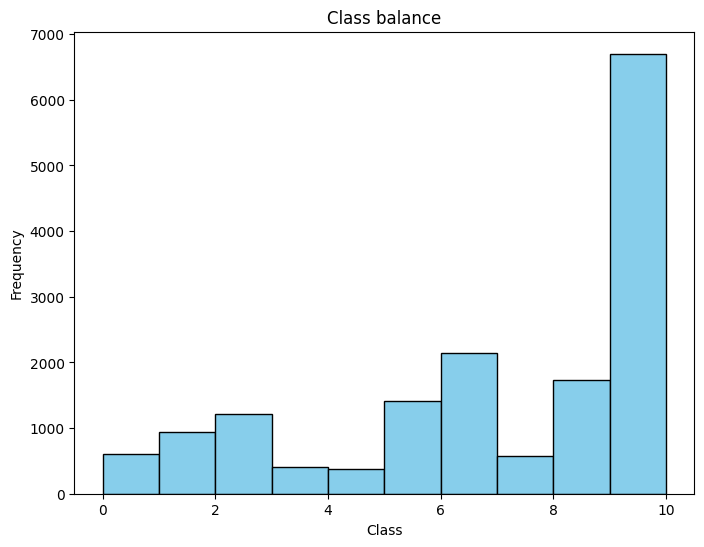

In [140]:
print(data.info())

print(data.describe())

print(data.isna().count())

data = data.drop_duplicates(subset=['Artist Name', 'Track Name'], keep='first')

plt.figure(figsize=(8, 6))
plt.hist(data['Class'], color='skyblue', edgecolor='black')
plt.title('Class balance')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

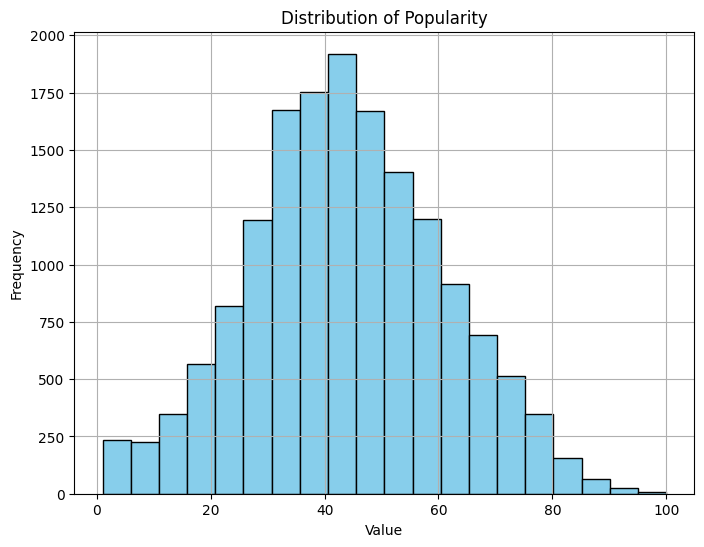

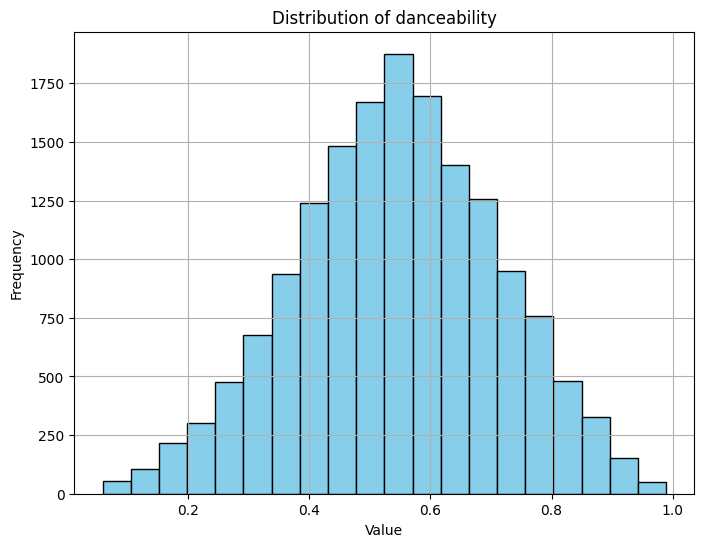

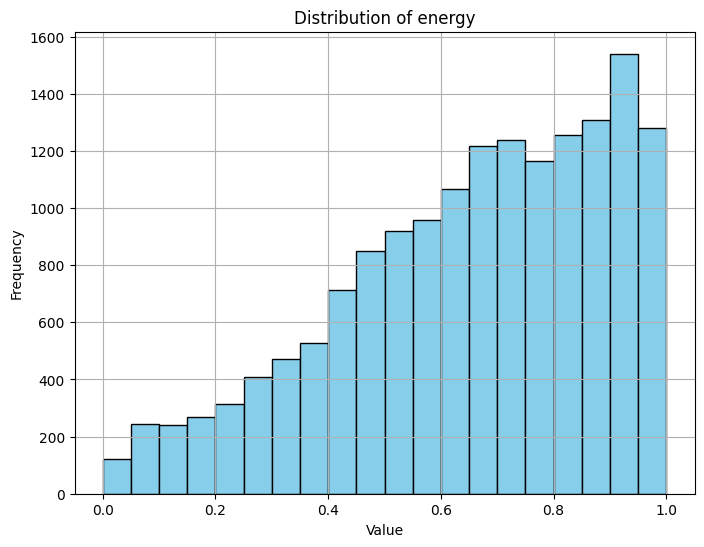

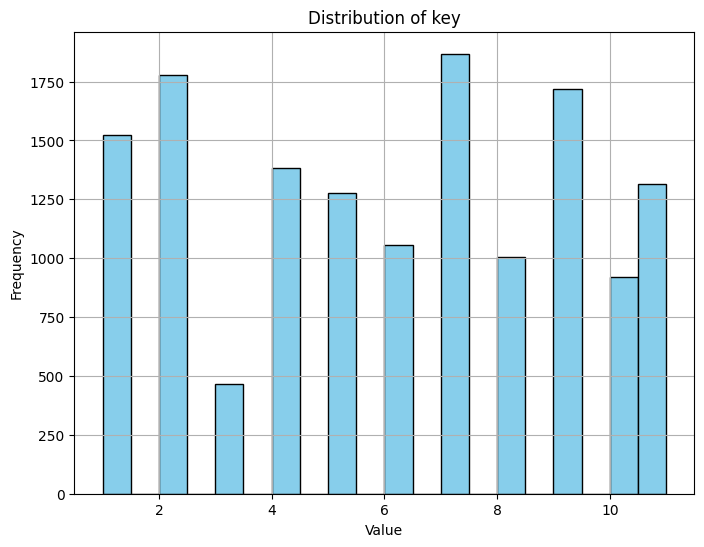

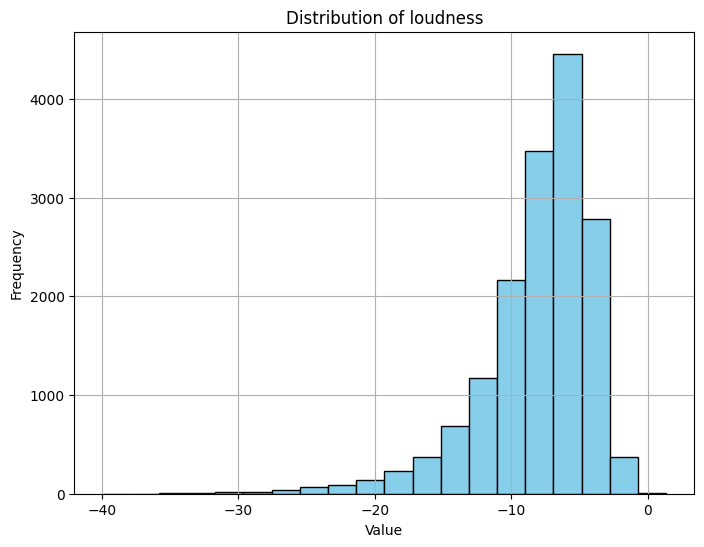

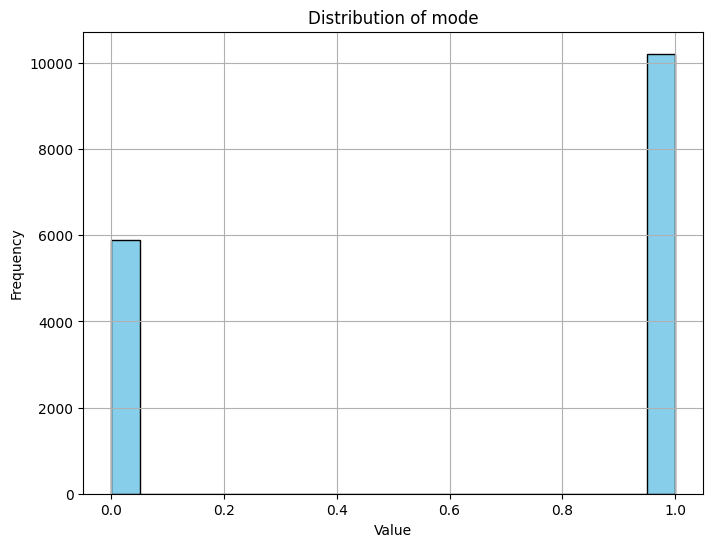

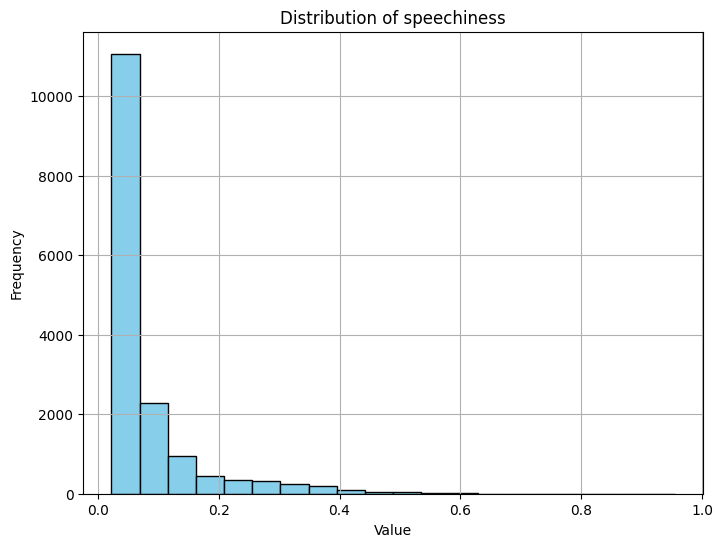

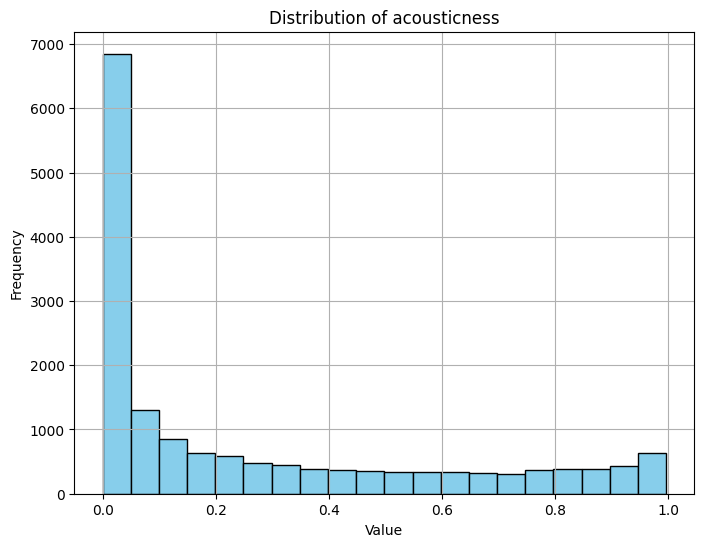

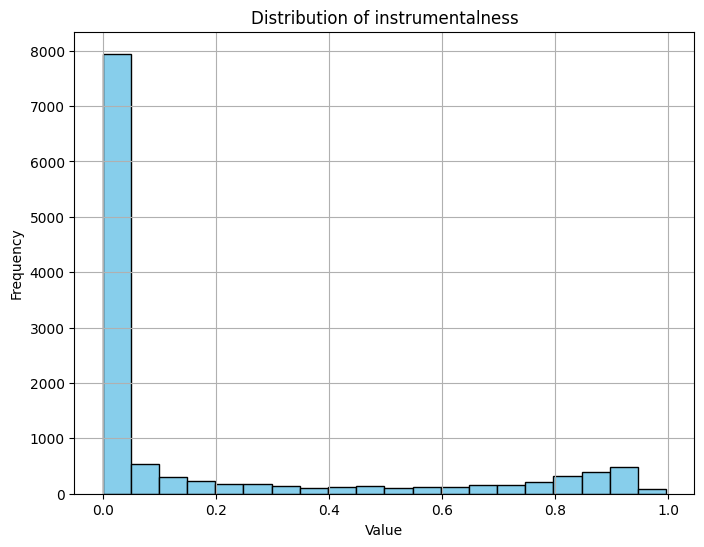

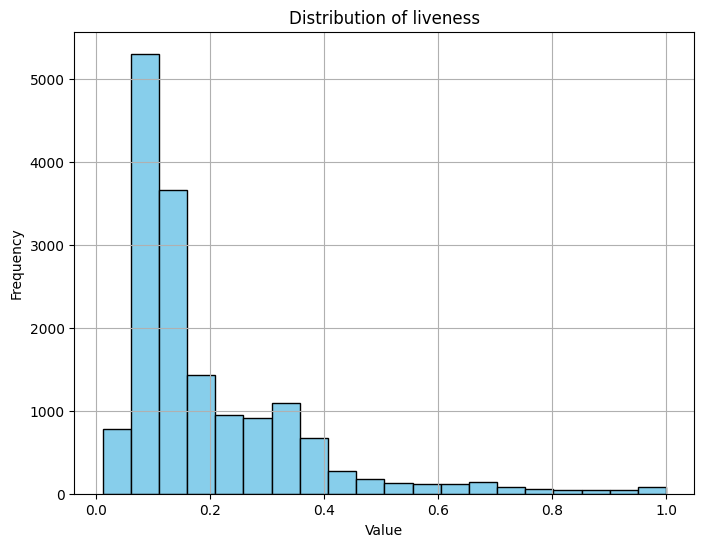

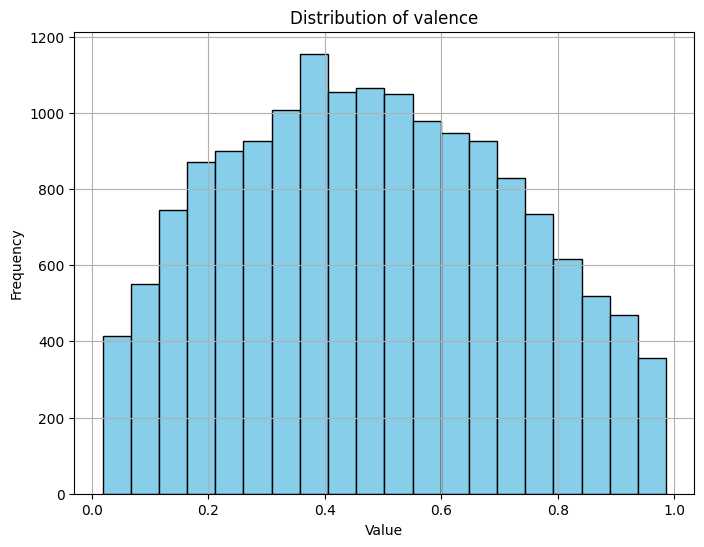

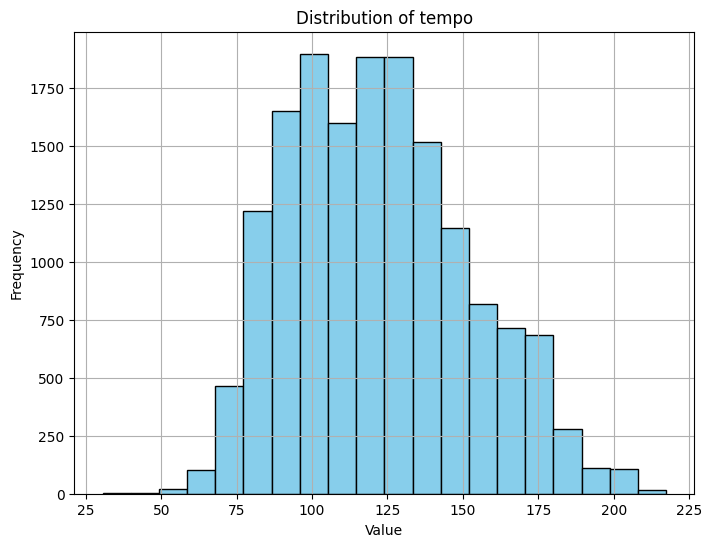

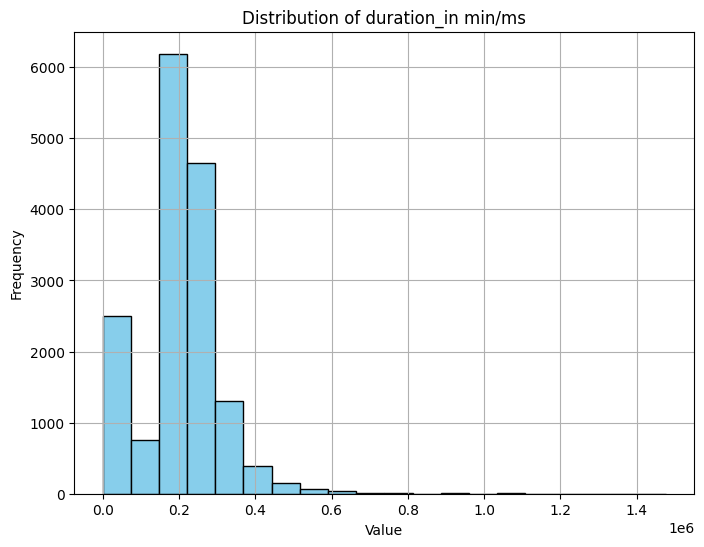

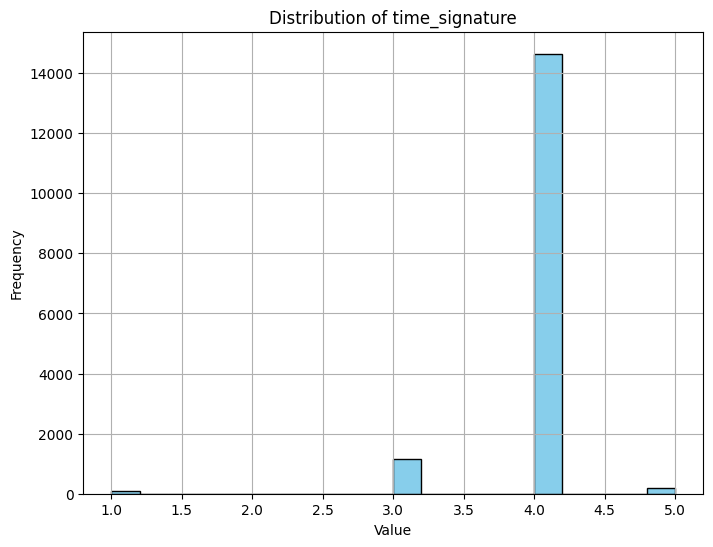

In [141]:
data1 = data.drop(columns=['Class', 'Artist Name', 'Track Name'])


for column in data1.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(data1[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

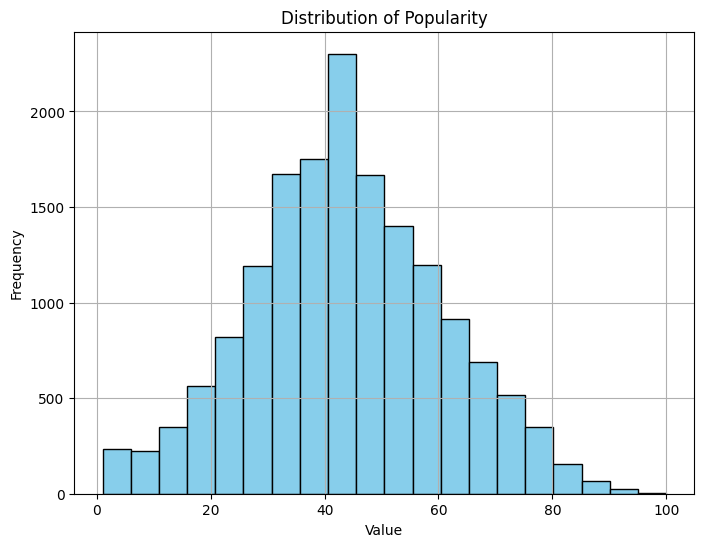

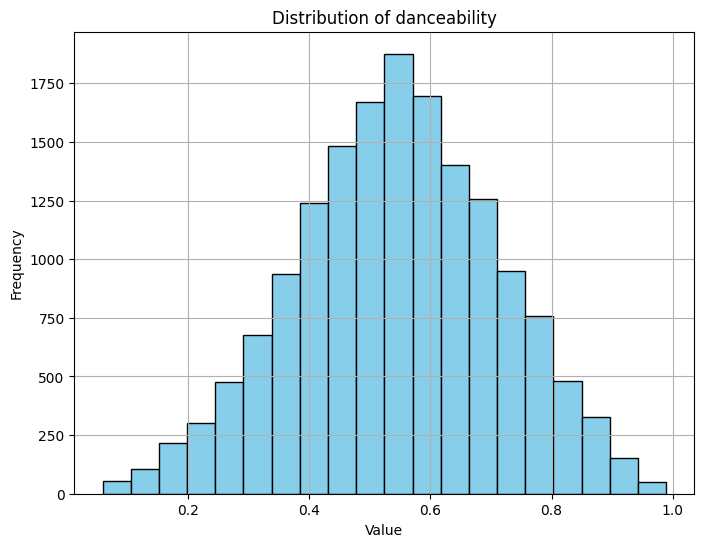

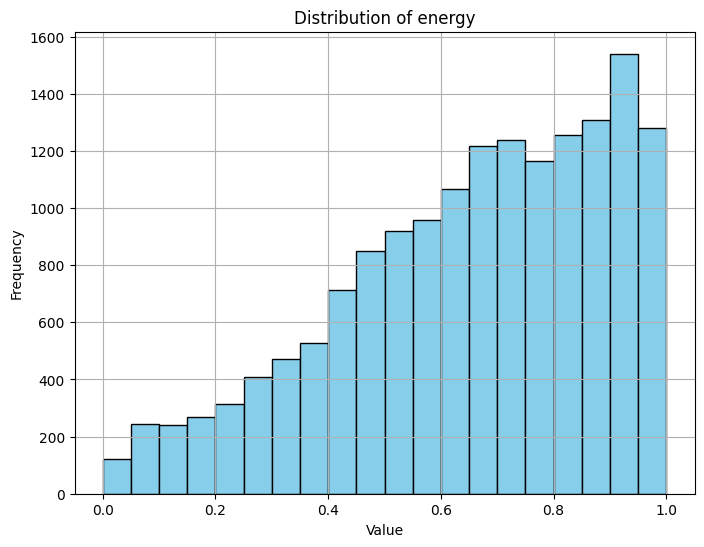

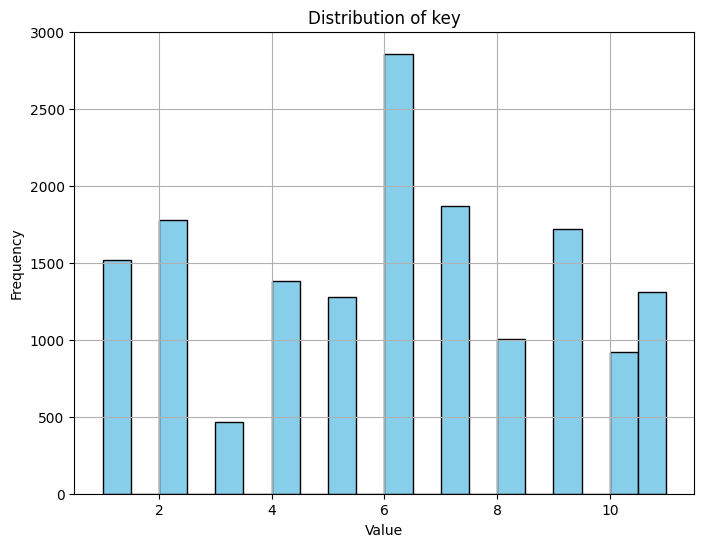

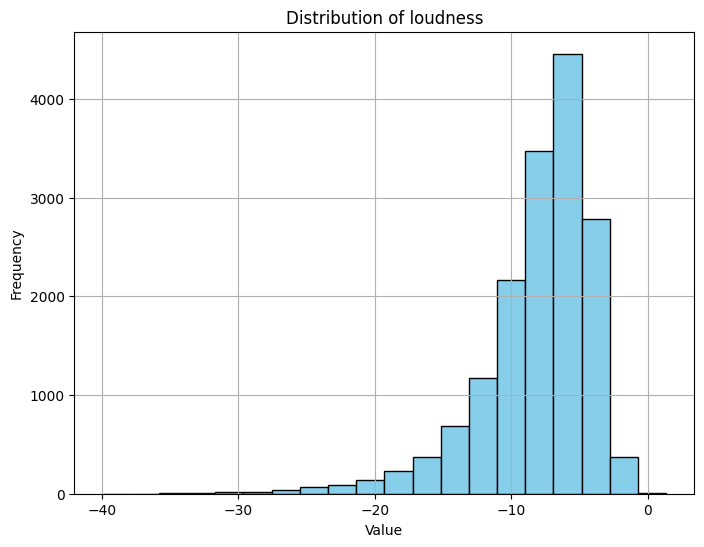

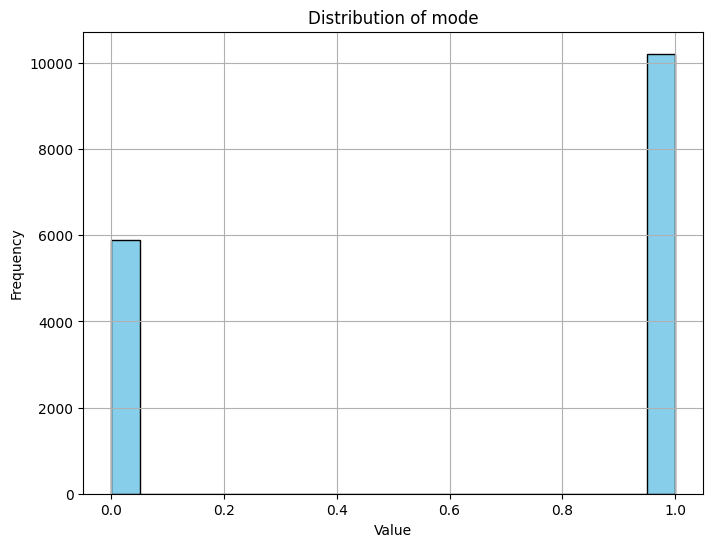

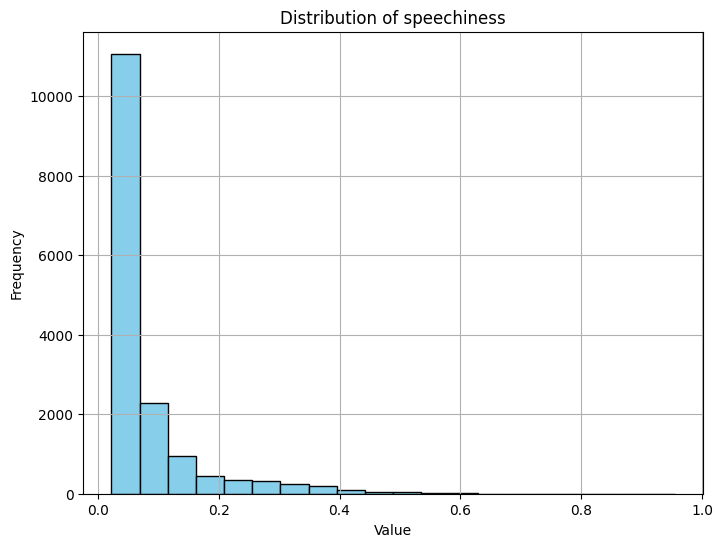

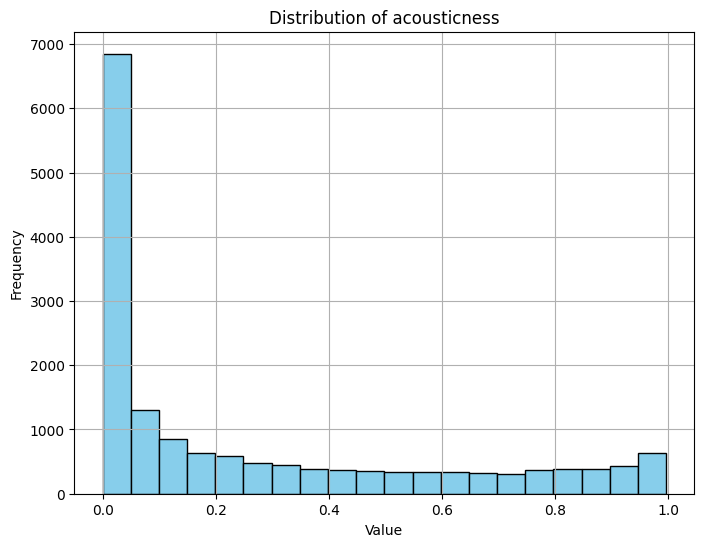

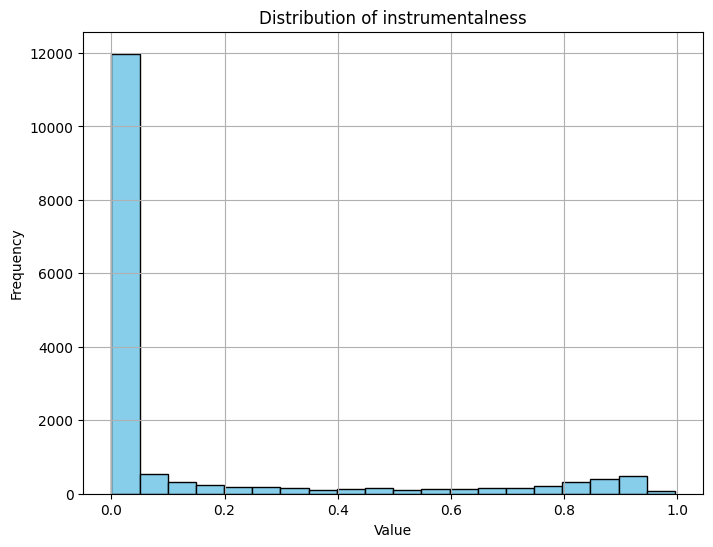

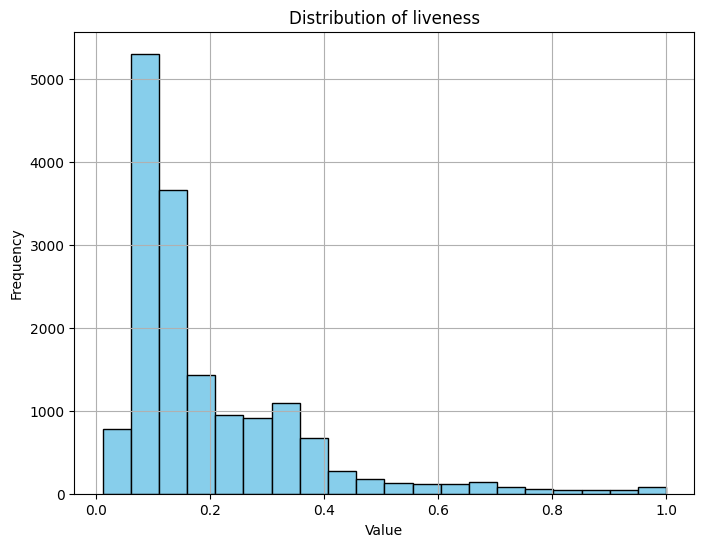

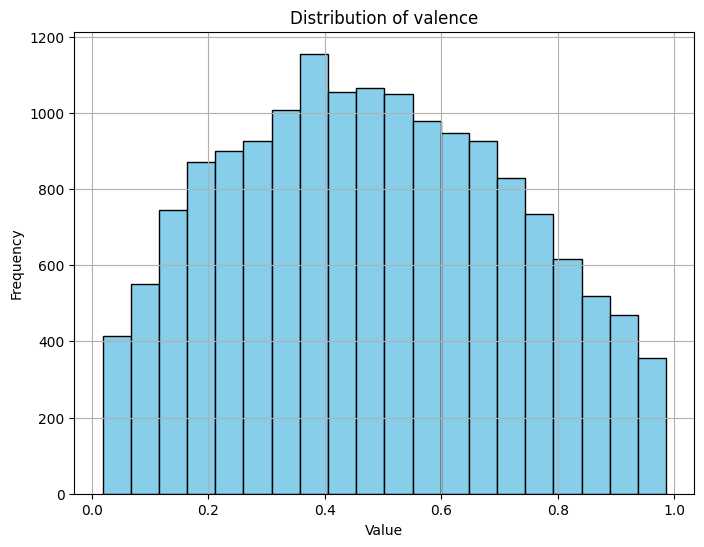

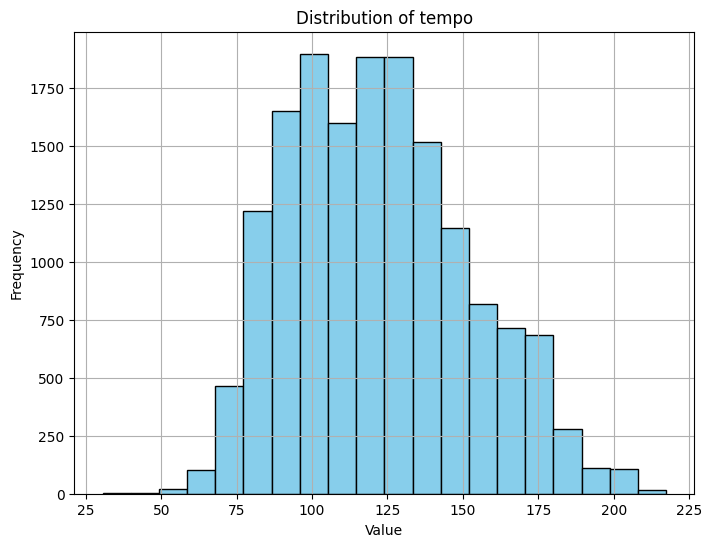

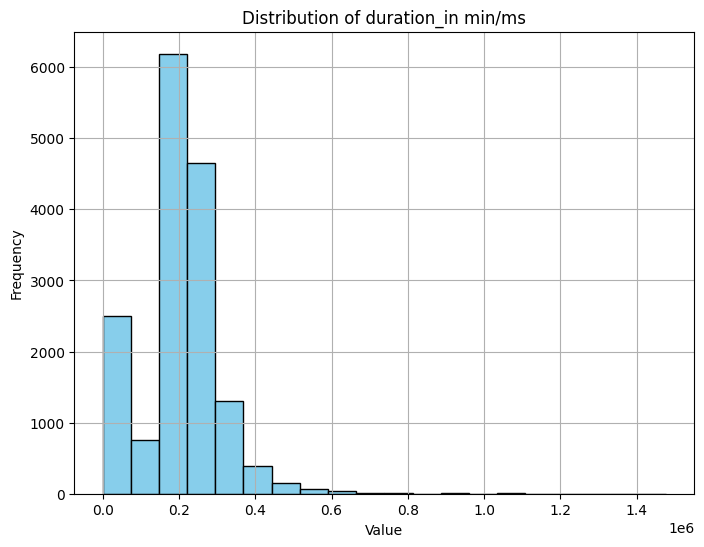

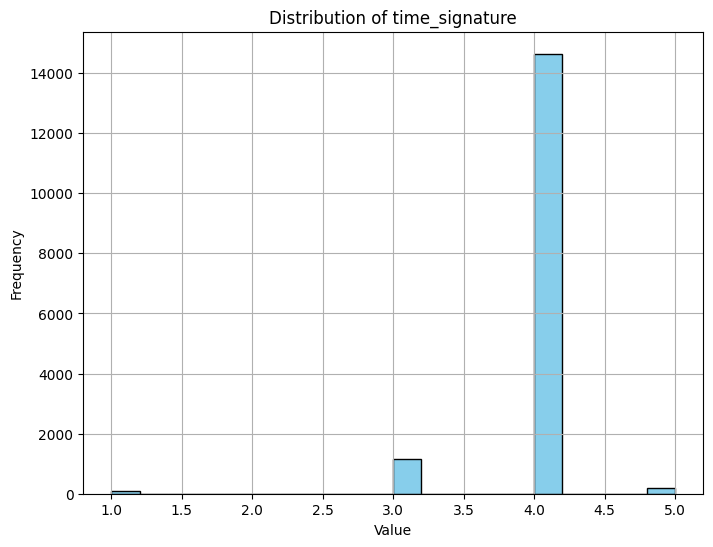

In [142]:
data1 = data1.fillna(data1.median())

for column in data1.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(data1[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [143]:
col_list = data.select_dtypes(exclude=['category', 'object'])

for column in col_list:
    data[column] = data[column].fillna(data[column].median())

data = data.dropna()

Многие данные имеют значительные выбросы, однако исходя из их названий можно сделать вывод, что это все же их особенность, поэтому было принято решение оставить их без изменений. Были отброшены все дубликаты комбинации названий исполнителей и треков. Все пропущенные значения были заменены на медианные, так как их исключение существенно уменьшает исходную выборку. 

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [144]:
enc = OrdinalEncoder()

categorical_cols = ['Artist Name', 'Track Name']
encoded_data = enc.fit_transform(data[categorical_cols])
data[categorical_cols] = encoded_data

In [204]:
X = data.drop(columns=['Class', 'Track Name'])
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

model = DecisionTreeClassifier(random_state=SEED)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range (8, 11),
    'min_samples_leaf': range (2,6),
    'min_samples_split': range (4,6)}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

y_pred = grid_search.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 4}
Accuracy Score: 0.5080695220360025
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       130
           1       0.19      0.04      0.07       163
           2       0.33      0.37      0.35       242
           3       0.74      0.65      0.70        75
           4       0.60      0.70      0.65        81
           5       0.64      0.67      0.66       266
           6       0.41      0.33      0.36       466
           7       0.87      0.89      0.88       116
           8       0.60      0.59      0.60       350
           9       0.50      0.42      0.45       462
          10       0.46      0.59      0.51       871

    accuracy                           0.51      3222
   macro avg       0.55      0.54      0.54      3222
weighted avg       0.50      0.51      0.50      3222



Не очень получилось, к сожалению, подобрать необходимые значения гиперпараметров, что привело к низкому значению Accuracy. Хуже всех из всех классов определялся 1, при возрастании значений показателя ограничения количество объектов и в листах он снижался еще сильнее. Практически при любых испробованных значениях класс 7 определялся хорошо.

TypeError: can only concatenate str (not "numpy.int64") to str

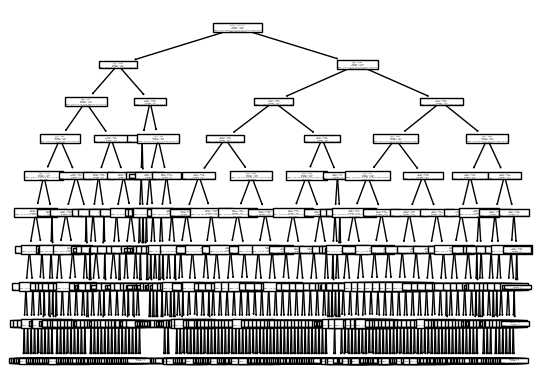

In [206]:
plt.figure()
model1 = DecisionTreeClassifier(criterion= 'entropy', max_depth= 9, min_samples_leaf= 3, min_samples_split= 4)
tree.plot_tree(model1.fit(X_train, y_train)) 


dot_data = tree.export_graphviz(model1, out_file=None, 
                              feature_names=X_train.columns,  
                              class_names=y_train,  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(dot_data) 

graph 

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24552 sha256=4d5ae1b88c372a2deee830e5f730b89b3fb2bd051d9e852ab1aeaa52cd05f730
  Stored in directory: /home/dorzhi/.cache/pip/wheels/bd/ce/e8/ff9d9c699514922f57caa22fbd55b0a32761114b4c4acc9e03
Successfully built pydotplus
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 364.6 kB/s eta 0:00:00a 0:00:01


### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Довольно сомнительный фильм с исторической точки зрения про Рассела Кроу и Хоакина Феникса. Очень красиво снят, по моему мнению. Да и всегда приятно посмотреть на Римскую империю.

2. Фильм, который Клинт Иствуд снял про автомобиль с собой в главной роли. Весь хронометраж старик не позволяет проявлять в свою сторону неуважение от меньшинств, но в конце фильм довольно трогательный.

3. Фильм, где Марк Уолберг, Скала и миньон Капитана Америки придумывают очень хитроумный, как им кажется, план для быстрого улучшения материального положения (в целом, они половину фильма качались, а другую жутко тупили). Это, конечно, не "Трансформеры" или "Армагеддон", но сразу видно, что снимал Майкл Бэй.